In [78]:
import os
from subprocess import run
res = run(["git", "rev-parse", "--show-toplevel"], capture_output=True)
root_dir = res.stdout.decode().strip()
os.chdir(root_dir)

def select_subarray(nlow, nhigh, *args):
    rv = []
    for x in args:
        rv.append(x[nlow:nhigh])
    return rv

# Detecting stuctures in simulation data

## Allication of computervision to hydrodynamic simulations


---
Thomas Rometsch

__CPT-SEMINAR 11.05.2021__

# Experiment in progress ...
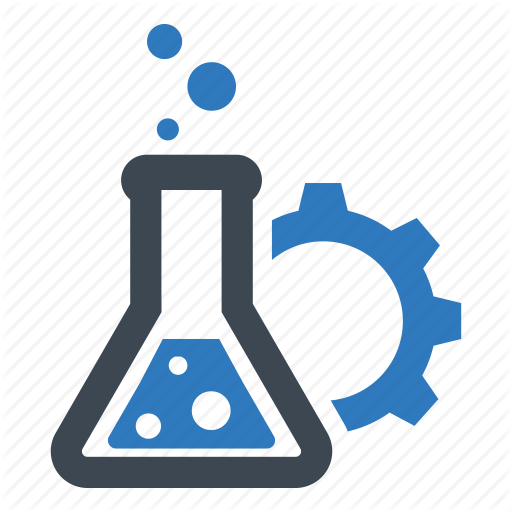

This presentation is done complete inside a _Jupyter Notebook_.

Let's hope it works!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## The Problem to be solved
---

Vortices appear in low viscosity simulations.

### Challenge

Detect vortices in at least $100\ \mathrm{sims}$ $\times\ 500\ \frac{\mathrm{snapshots}}{\mathrm{sim}}$ $=\ 50\,000\ \mathrm{snapshots}$.

### By hand

With 5 sec per snapshots to decide on vortex or not:

250 000 sec = 4167 min = 69.5 hours = 8.68 workdays

_Actually, I would like to know how_ __large__ _and_ __massive__ _the vortex is. And maybe also its_ __orbital elements__...

## The important quantity

We use the vortensity as a quantitative measure of the existence of a vortex.

Vorticity = $(\nabla \times \vec{v}) \cdot \hat{z}$

Vortensity = vorticity / density = $\varpi$ = $\frac{(\nabla \times \vec{v}) \cdot \hat{z}}{\Sigma}$

---

Acutally, we use $\frac{\varpi}{\varpi_0}$ with 

$\varpi$ = $\frac{(\nabla \times (\vec{v} - \vec{v}_\mathrm{Kepler}) \cdot \hat{z}}{\Sigma}$

$\varpi_0 = \frac{(\nabla \times \vec{v}_\mathrm{Kepler}) \cdot \hat{z}}{\Sigma_0}$.

Thus, the meaningful values are in the __range of -1 to 1__!

In [3]:
%matplotlib inline
from matplotlib import colors
def colormesh_plot(ax, X , Y, Z, label="", vmin=None, vmax=None, levels=None, cmap="magma", vlim=None, logscale=False):
    if vlim is None:
        if levels is not None:
            vlim = (levels[0], levels[-1])
        else:
            vlim = (vmin, vmax)
    if logscale:
        norm = colors.LogNorm(vmin=vlim[0], vmax=vlim[-1])
    else:
        norm = colors.Normalize(vmin=vlim[0], vmax=vlim[-1])
    im = ax.pcolormesh(X, Y, Z, norm=norm, cmap=cmap, shading="auto")
    if levels is not None:
        ax.contour(X,Y,Z,cmap="viridis", levels=levels)          
    cbar = ax.get_figure().colorbar(im, ax=ax, orientation="horizontal")
    cbar.set_label(label)


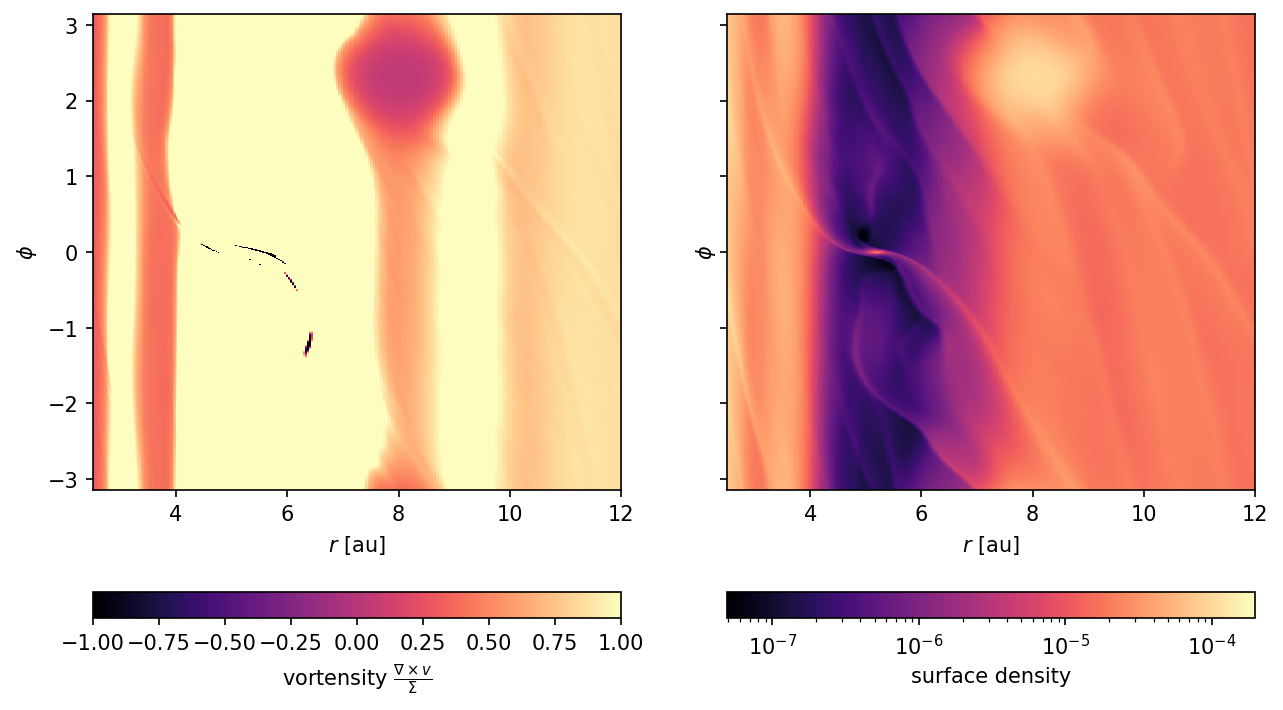

In [79]:
%matplotlib inline
from simdata_vorticity import provide_simulation_data
R, Phi, A, Vortensity, Vorticity, Rho, Rho_background = provide_simulation_data("3625e016", 200)
fig, axes = plt.subplots(1,2,dpi=150, sharex="all", sharey="all", figsize=(10,6))
colormesh_plot(axes[0], R, Phi, Vortensity, r"vortensity $\frac{\nabla \times v}{\Sigma}$", vmin=-1, vmax=1)
colormesh_plot(axes[1], R, Phi, Rho, "surface density", logscale=True)
for ax in axes:
    axes[0].set_xlim(2.5, 12)
    ax.set_xlabel("$r$ [au]")
    ax.set_ylabel("$\phi$")

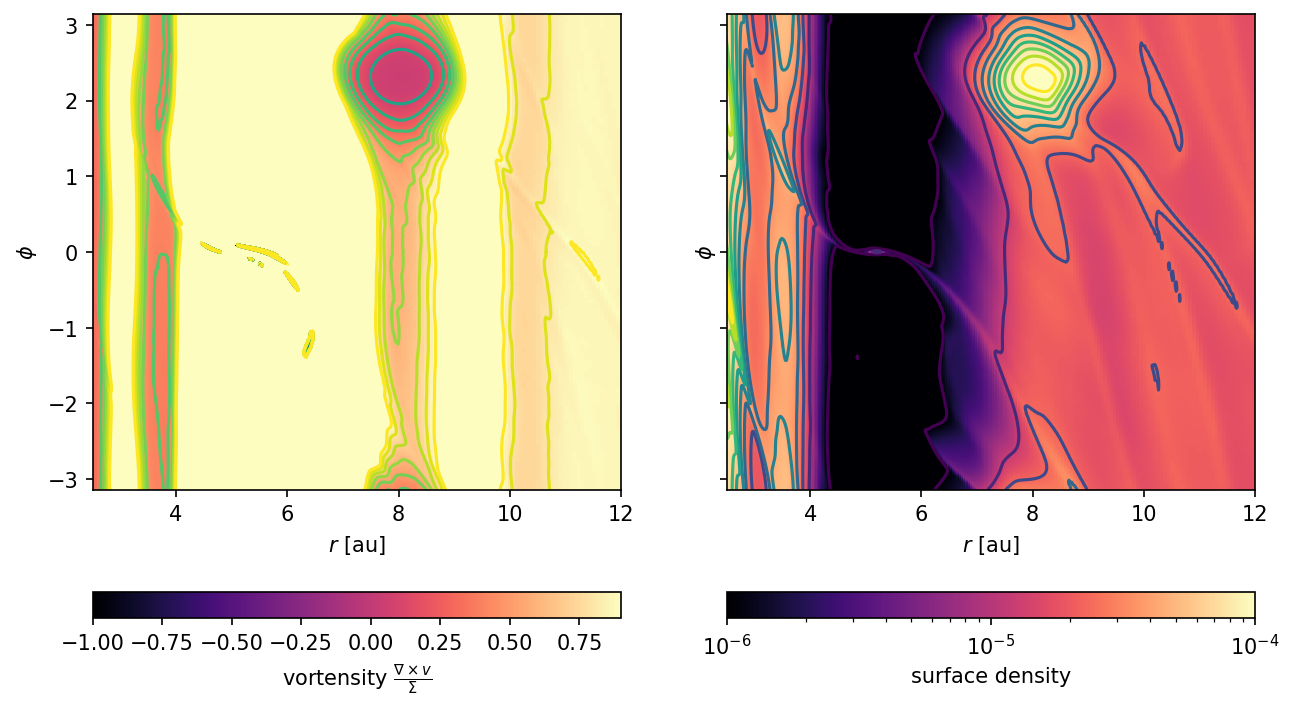

In [5]:
fig, axes = plt.subplots(1,2,dpi=150, sharex="all", sharey="all", figsize=(10,6))
colormesh_plot(axes[0], R, Phi, Vortensity, 
               r"vortensity $\frac{\nabla \times v}{\Sigma}$", levels=np.arange(-1,1,0.1))
colormesh_plot(axes[1], R, Phi, Rho, "surface density", logscale=True, levels=np.linspace(1e-6, 1e-4, 10))
for ax in axes:
    axes[0].set_xlim(2.5, 12)
    ax.set_xlabel("$r$ [au]")
    ax.set_ylabel("$\phi$")

# Detecting Vortices

<img src="../logo.svg" style="max-height: 40vh; left: 0">

made with [game-icons.net](https://game-icons.net) in 2 min

In [8]:
from src.vortector.vortector import Vortector

## Structures in vortensity

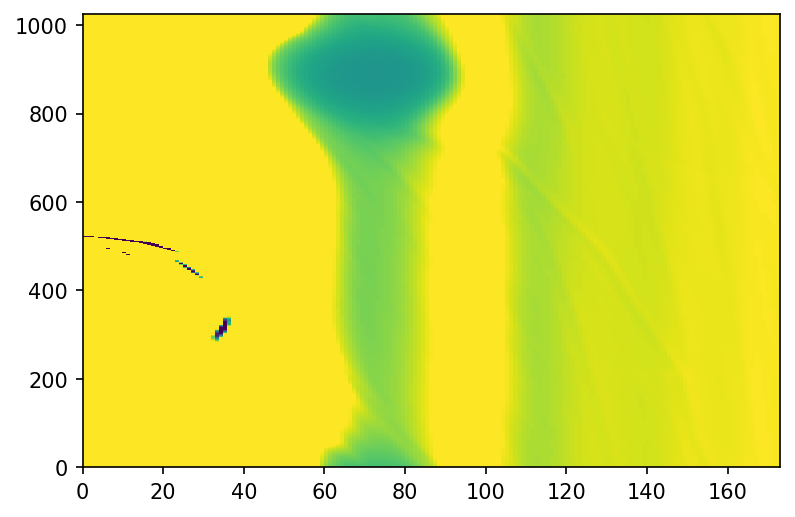

In [86]:
Rlim = [5.2, 15]
nlow = np.argmin(np.abs(R[:,0] - Rlim[0])).astype(np.int32)
nhigh = np.argmin(np.abs(R[:,0] - Rlim[-1])).astype(np.int32)
R, Phi, A, Vortensity, Rho = select_subarray(nlow, nhigh, R, Phi, A, Vortensity, Rho)

def show_img(arr):
    fig, ax = plt.subplots(dpi=150)
    ax.pcolormesh(arr.T)
    return fig, ax
    

vort = Vortensity.copy()
vort[vort > 1] = 1
vort[vort < -1] = -1
fig, ax = show_img(vort)

## Seeing double
Dealing with periodic boundaries

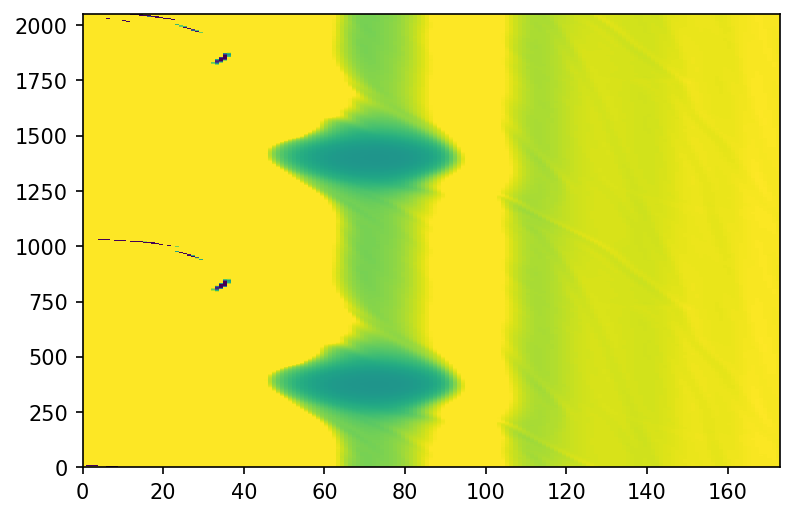

In [87]:
from src.vortector.contour import *

data = vort
Nx, Ny = data.shape
data, pad = extend_array(data)

fig, ax = show_img(data)

## Contour extraction using OpenCV

In [12]:
import cv2 # python wrapper for OpenCV (Open Computer Vision)
def contour_threshold(data, threshold):
    image = data < threshold
    image = image.astype(np.uint8)
    contours, _ = cv2.findContours(
        image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

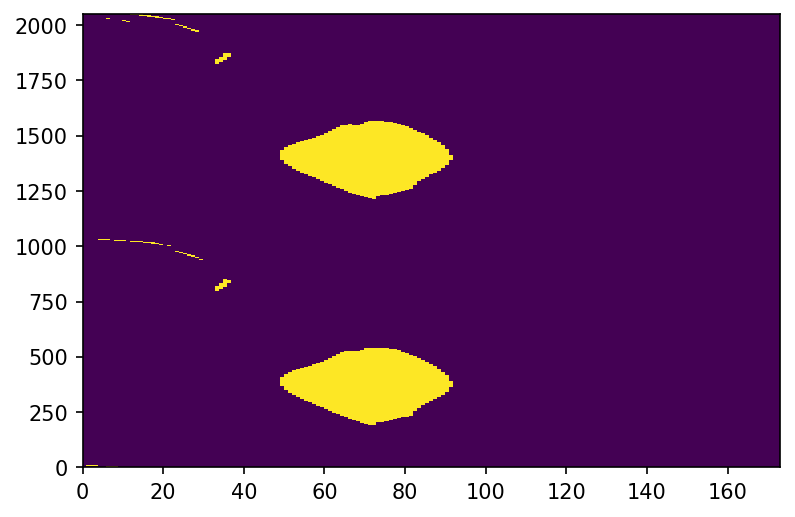

In [88]:
fig, ax = show_img(data < 0.5)

## OpenCV find_contour output

In [89]:
levels = np.arange(-1, 1, 0.05)

#call cv2.find_contour from OpenCV
contours_largest = find_contours(data, levels) 
contours_largest[0]

{'boundary': array([[[193, 103]],
 
        [[192, 104]],
 
        [[191, 104]],
 
        ...,
 
        [[196, 103]],
 
        [[195, 103]],
 
        [[194, 104]]], dtype=int32),
 'contour_value': 0.9500000000000017,
 'opencv_contour_number': 39000,
 'uuid': 'f4fab037-06e9-42bf-bbb3-bbd3c0412a17',
 'pixel_area': 114806.0}

## Contour on the data

In [90]:
def draw_contours(ax, contours):
    for c in contours:
        bnd = c["boundary"]
        ax.plot(bnd[:,0,1], bnd[:,0,0])

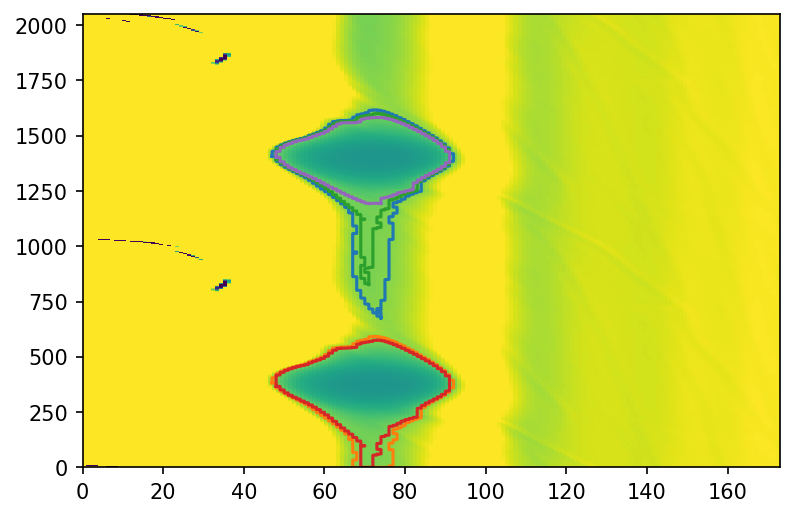

In [92]:
fig, ax = show_img(data)
draw_contours(ax, contours_largest[10:15])

## Clean up

Removed 12 contours which were duplicates. 20 remaining.


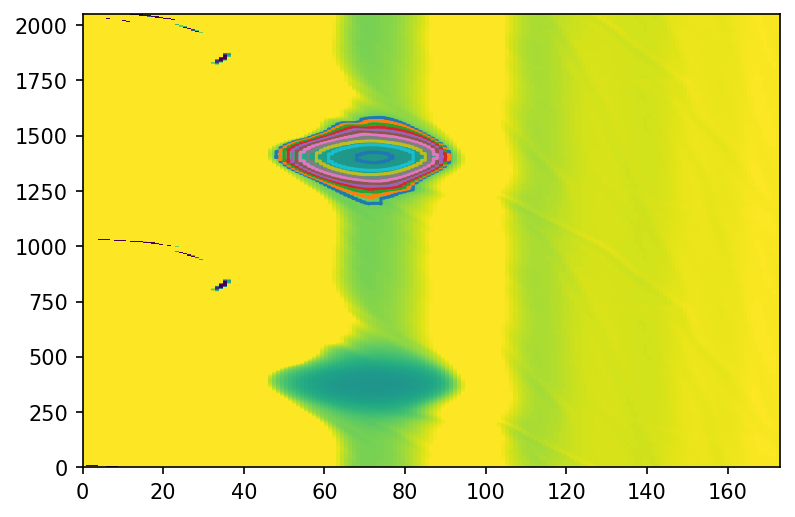

In [93]:
contours_closed = extract_closed_contours(
    pad, Nx, Ny, contours_largest, 100, periodic=True)
contours = {n : c for n,c in enumerate(contours_closed)}

remove_duplicates_by_geometry(contours_closed, verbose=True)

contours = {n : c for n,c in enumerate(contours_closed)}

max_ellipse_deviation = 0.15
contours = extract_ellipse_contours(data.shape, contours_closed, max_ellipse_deviation)

fig, ax = show_img(data)
draw_contours(ax, [c for c in contours.values()])

## Putting all together

In [94]:
vt = Vortector(R, Phi, A, Vortensity, Rho)
%time vortices = vt.detect(include_mask=True, autofit=False)

CPU times: user 118 ms, sys: 48 ms, total: 166 ms
Wall time: 72 ms


In [95]:
import pprint as pp
pp.pprint(vortices[0]["contour"]["stats"])

{'area': 25.738895180894275,
 'azimuthal_at_surface_density_max': {'surface_density_avg': 3.553893372694304e-05,
                                      'surface_density_med': 2.3783189464071736e-05,
                                      'surface_density_min': 0.00010688185597783761},
 'azimuthal_at_vortensity_min': {'vortensity_avg': 0.4790988422537555,
                                 'vortensity_max': 0.7372561239214194,
                                 'vortensity_med': 0.5916800380387961},
 'height': 2.3930100291016,
 'mass': 0.0013952657483861782,
 'phimax': -2.856272227043064,
 'phimin': 1.033903051034922,
 'rmax': 6.946515510100817,
 'rmin': 9.028474937528504,
 'surface_density_avg': 5.3754592933366076e-05,
 'surface_density_max': 0.00010688185597783761,
 'surface_density_max_inds': (73, 889),
 'surface_density_max_pos': (8.090164475824862, 2.3163109897073184),
 'surface_density_med': 4.8411208026158956e-05,
 'surface_density_min': 1.8215432156631997e-05,
 'vortensity_avg': 0.270

## Numbers are nice .. but I want plots!

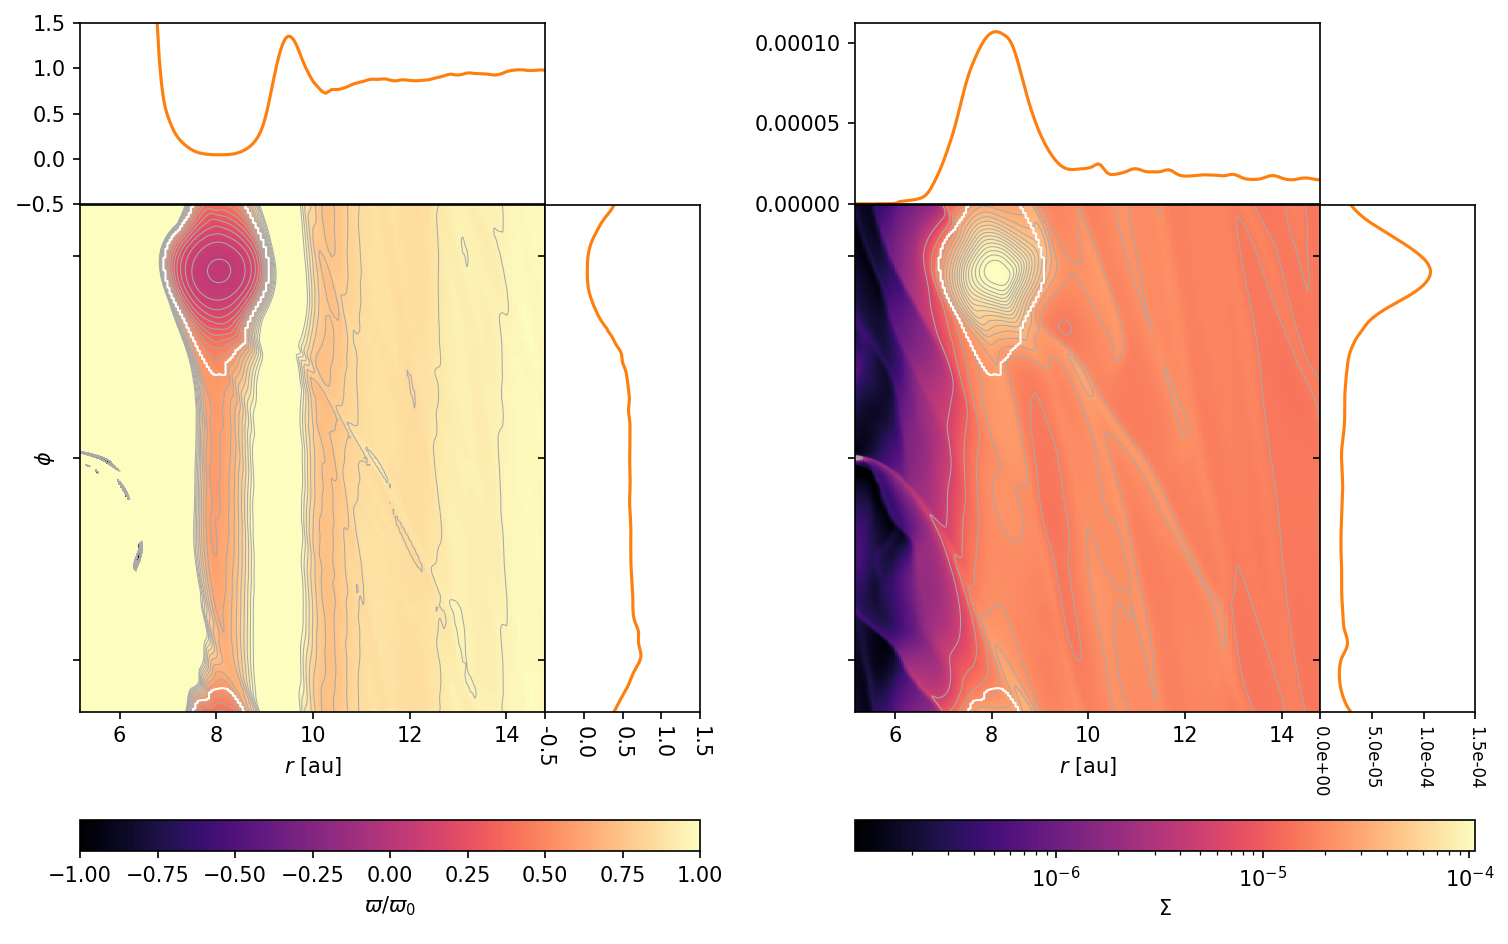

In [96]:
from src.vortector.visualize import show_fit_overview_2D
show_fit_overview_2D(vt, n=0)

## 2D Gaussian fits

CPU times: user 405 ms, sys: 217 ms, total: 622 ms
Wall time: 152 ms


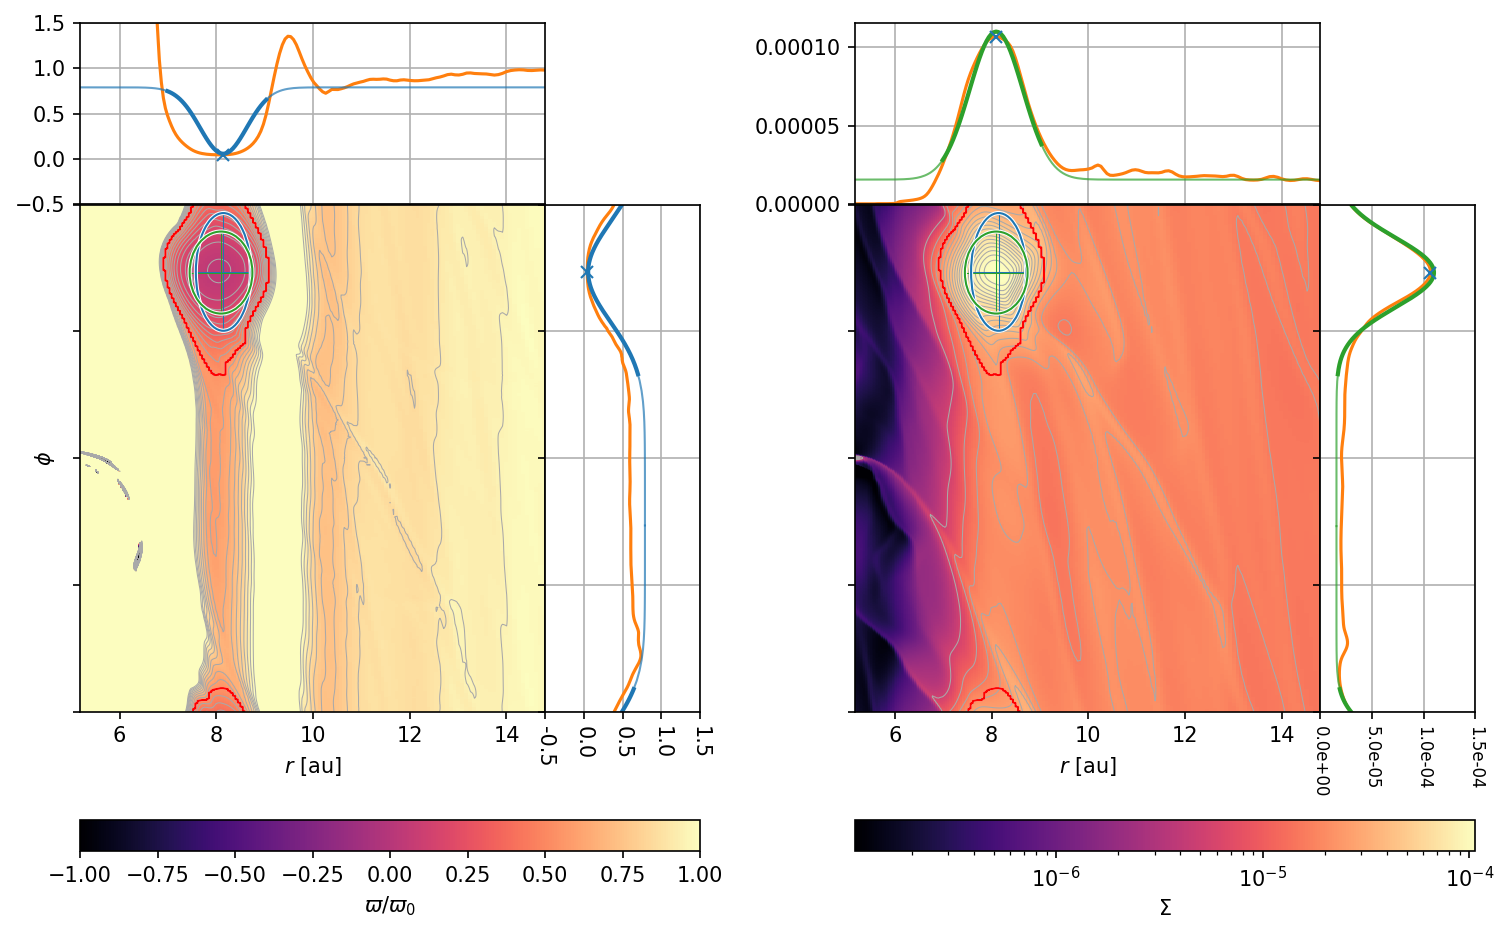

In [97]:
%time vortices = vt.detect(include_mask=True, autofit=True)
show_fit_overview_2D(vt, n=0)

# Profiling

What's taking so long?

In [98]:
# python3 -m pip install snakeviz
%load_ext snakeviz

In [106]:
%snakeviz vortices = vt.detect()

 
*** Profile stats marshalled to file '/tmp/tmp9n7_54cs'. 
Embedding SnakeViz in this document...


## A simple example

Plot of the factorial function.

In [124]:
def factorial(n):
    rv = n
    for k in range(n-1, 0, -1):
        rv *= k
    return rv
%time rv = factorial(3)
%time rv = factorial(10)
%time rv = factorial(1000)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.54 µs
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.58 µs
CPU times: user 281 µs, sys: 0 ns, total: 281 µs
Wall time: 302 µs


In [122]:
from numba import njit

@njit(cache=True)
def factorial(n):
    rv = n
    for k in range(n-1, 0, -1):
        rv *= k
    return rv
%time rv = factorial(3)
%time rv = factorial(10)
%time rv = factorial(100000)

CPU times: user 75.1 ms, sys: 7.92 ms, total: 83 ms
Wall time: 82.8 ms
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs
CPU times: user 48 µs, sys: 5 µs, total: 53 µs
Wall time: 55.3 µs


# Optimization

Python code is just slow, right?

### Meet __just in time compilation__!

In [25]:
from numba import jit

# Summary
---

### Physical Problem to Solve

Detecting Vortices in Disks

---

### The Vortector

<img src="../logo.svg" style="max-height: 4em; position: relative">

---

### Profiling 

The `snakeviz` package.

---

### Optimization
Just in time compilation with `numba`.